In [120]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from skimage import data, io, filters

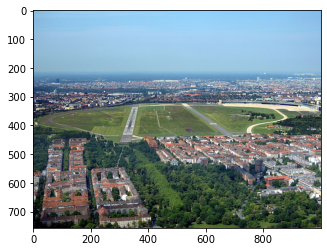

In [123]:
tempelhof = io.imread("schraegbild_tempelhof.jpg")
tempelhof = skimage.util.img_as_float(tempelhof)
plt.imshow(tempelhof)

In [124]:
xy_dash_0 = [312,432] # Unten links
xy_dash_1 = [343,432] # Unten rechts
xy_dash_2 = [344,338] # Oben links
xy_dash_3 = [364,338] # Oben rechts
Passpoints = [xy_dash_0, xy_dash_1, xy_dash_2, xy_dash_3]
print(len(Passpoints))

xy_0 = [0,0]  # Unten links
xy_1 = [40,0] # Unten rechts
xy_2 = [0,1640]  # Oben links
xy_3 = [40,1640] # Oben rechts
real = [xy_0, xy_1, xy_2, xy_3]

print(Passpoints)
print(real)

4
[[312, 432], [343, 432], [344, 338], [364, 338]]
[[0, 0], [40, 0], [0, 1640], [40, 1640]]


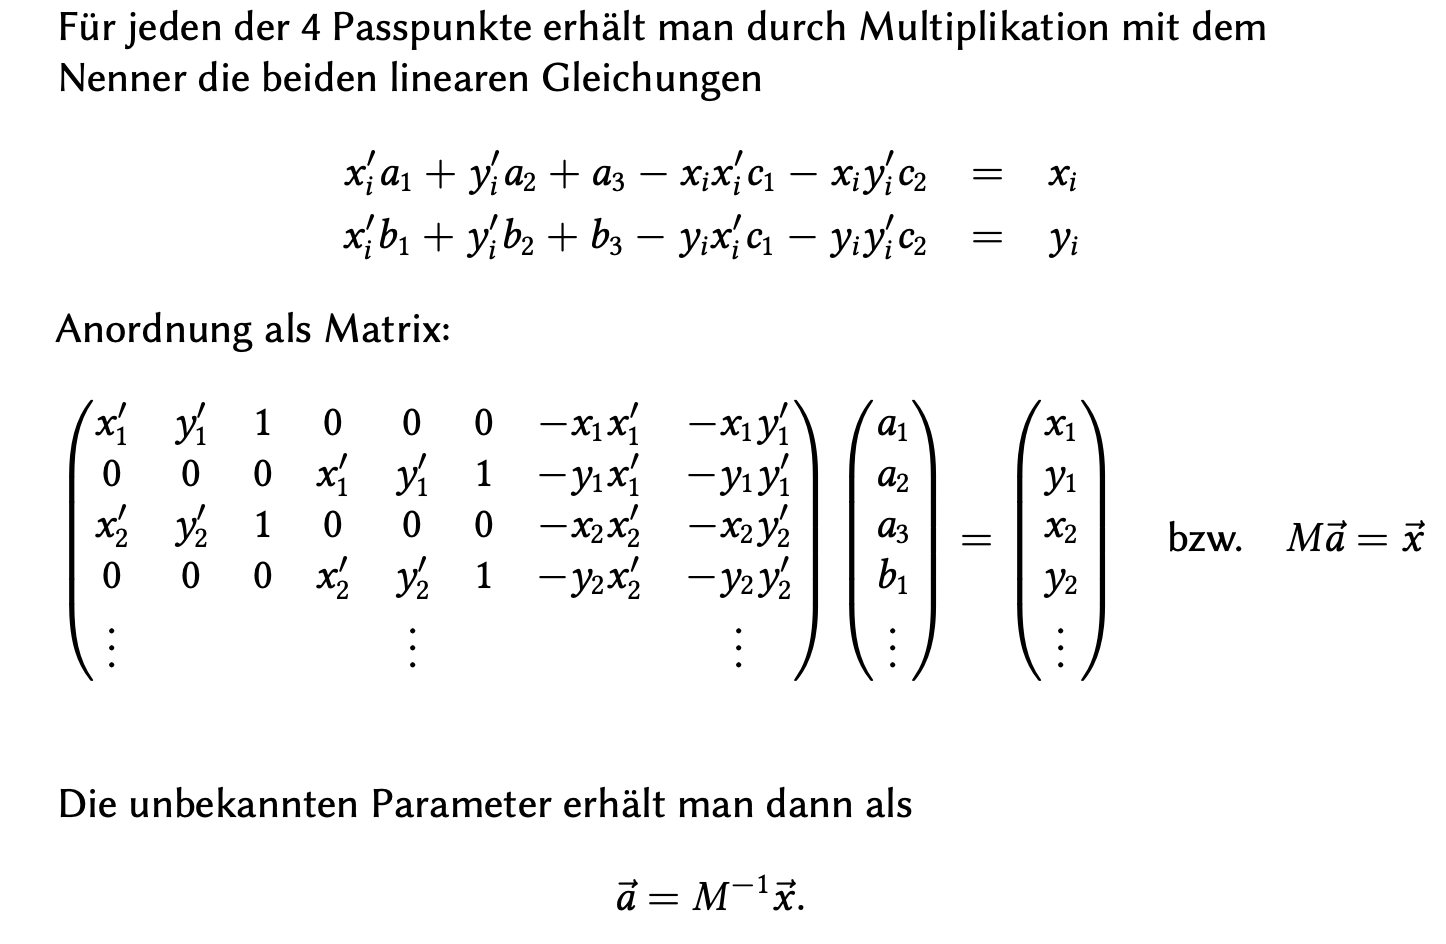

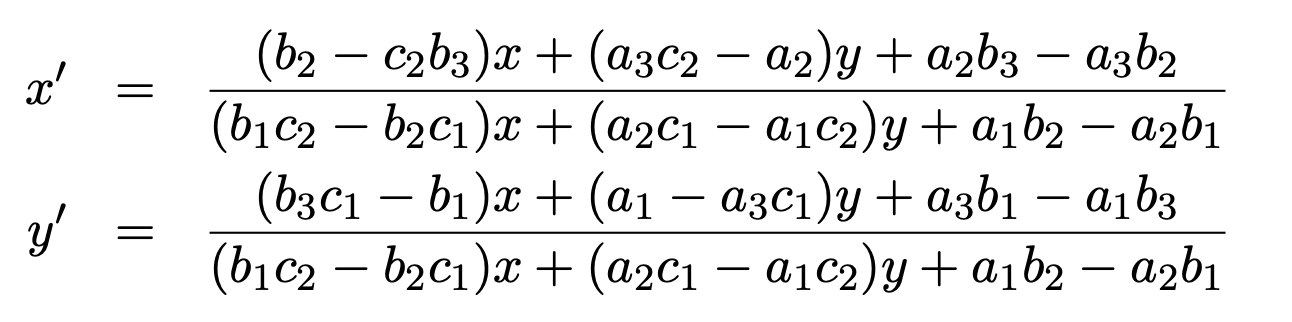

In [125]:
def projectiv_transform(PassPoints, real, img, new_img, interpolation, TransMat, scale, vec):
    
    
    M = np.zeros([8,8])
    x_vec = np.zeros([8,1])
    
     # Füllen des Vektors mit den Objektpunkten                                         
    for i in range(0,7,2):
        x_vec[i] = real[int(i/2)][0]
        x_vec[i+1] = real[int(i/2)][1]
        
        
    # Berechnen der Matrix
    
    for i in range(0,7,2):
        M[i][0] = PassPoints[int(i/2)][0]
        M[i][1] = PassPoints[int(i/2)][1]
        M[i][2] = 1
        M[i][3] = 0
        M[i][4] = 0
        M[i][5] = 0
        M[i][6] = -real[int(i/2)][0]*PassPoints[int(i/2)][0]
        M[i][7] = -real[int(i/2)][0]*PassPoints[int(i/2)][1]
        
        M[i+1][0] = 0
        M[i+1][1] = 0
        M[i+1][2] = 0
        M[i+1][3] = PassPoints[int(i/2)][0]
        M[i+1][4] = PassPoints[int(i/2)][1]
        M[i+1][5] = 1
        M[i+1][6] = -real[int(i/2)][1]*PassPoints[int(i/2)][0]
        M[i+1][7] = -real[int(i/2)][1]*PassPoints[int(i/2)][1]
    
    # Bilden der Inversen Rotationsmatrix
    M_inv = np.linalg.inv(M)
    

                                                
                                                
    # Berechnen der unbekannten Parameter  
    a_vec = np.dot(M_inv, x_vec)
    
    a1 = a_vec[0]
    a2 = a_vec[1]
    a3 = a_vec[2]
    b1 = a_vec[3]
    b2 = a_vec[4]
    b3 = a_vec[5]
    c1 = a_vec[6]
    c2 = a_vec[7]
    
    
    # -> Kamera kalibriert 
        
    y_new_len, x_new_len, z_new_len = img_new.shape
    y_len, x_len, z_len = img.shape
    
    TransMat = TransMat.dot(np.matrix([[scale[0], 0, 0], [0, scale[1], 0], [0, 0, 1]]))
    InvTransMat = np.linalg.inv(TransMat)
    
    for x_new in range(0, x_new_len):
        for y_new in range(0, y_new_len):
            
            coord = InvTransMat.dot([x_new, y_new, 1])
            x = coord[0,0] - vec[0]
            y = coord[0,1] - vec[1]
                                                

            #Berechnen der inversen Projektivtransformation
    
            x_old = ((b2-c2*b3)*x+(a3*c2-a2)*y+a2*b3-a3*b2)/((b1*c2-b2*c1)*x+(a2*c1-a1*c2)*y+a1*b2-a2*b1)
            y_old = ((b3*c1-b1)*x+(a1-a3*c1)*y+a3*b1-a1*b3)/((b1*c2-b2*c1)*x+(a2*c1-a1*c2)*y+a1*b2-a2*b1)
            
            if interpolation == "Nächster-Nachbar":
                x_old = int(np.rint(x_old))
                y_old = int(np.rint(y_old))
                if (0 <= x_old < x_len) and (0<= y_old < y_len):
                    img_new[y_new, x_new, :] =img[y_old,x_old,:]
            else:
                if interpolation == "Bilinear":
                    x0 = np.floor(x_old).astype(int)
                    x1 = x0 + 1
                    y0 = np.floor(y_old).astype(int)
                    y1 = y0 + 1
                    if (0 <= x0 < x_len) and (0<= y0 < y_len) and (0 <= x1 < x_len) and (0<= y1 < y_len):
                        P1 = img[ y0, x0 ]
                        P2 = img[ y1, x0 ]
                        P3 = img[ y0, x1 ]
                        P4 = img[ y1, x1 ]
                        A1 = (x1-x_old) * (y1-y_old)
                        A2 = (x1-x_old) * (y_old-y0)
                        A3 = (x_old-x0) * (y1-y_old)
                        A4 = (x_old-x0) * (y_old-y0)
                        img_new[y_new,x_new,:] = A1*P1 + A2*P2 + A3*P3 + A4*P4
                else:
                  print("Interpolationsmethode muss entweder 'Nächster-Nachbar' oder 'Bilinear' sein")

    return img_new



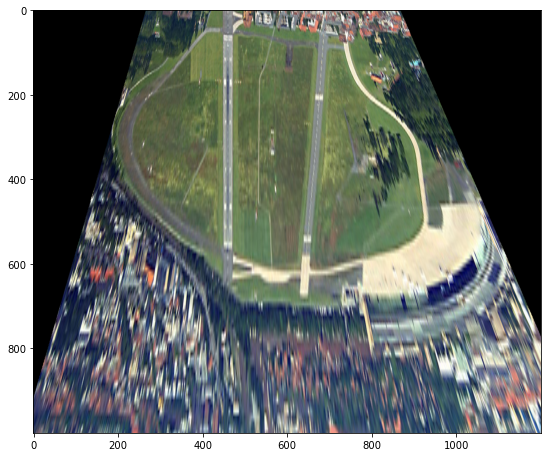

In [129]:
img_new = np.zeros(shape = (1000,1200,3))
Rotation = np.matrix([[np.cos(np.deg2rad(0)), -np.sin(np.deg2rad(0)), 0],
                  [np.sin(np.deg2rad(0)), np.cos(np.deg2rad(0)), 0], 
                  [0 ,0 , 1]])
scale = (0.5, 0.3)
trans_vec = np.array([900, 200, 0])
output = projectiv_transform(Passpoints, real, tempelhof, img_new, "Bilinear", Rotation, scale, trans_vec)
f = plt.figure(figsize=(20, 20))
f.add_subplot(1,2,1)
plt.imshow(output)